# Inspecting MIRISim Outputs

L.N. Fletcher (2021)

Outputs are normally placed in a date-labelled directory taking the form  <code> YYYYMMDD_hhmmss_mirisim</code>.  The name of the output directory is given in the last line of the MIRISim log.  Because the output directory is date-labelled, we can quantify which was the most recent run of MIRISim, and find its output directory using <code>glob.glob</code>.  In the notebook below, I've renamed the output directory as SHORT, MEDIUM or LONG for clarity.

The files contain the log which was also output to the terminal (<code> mirisim.log</code>) and copies of the .ini files used (or created from python inputs) to create the simulation. These versions of the .ini files can be used to re-create the run of the simulation

The directories contain various outputs of MIRISim:

* **<code> skycubes </code>** houses a 3D representation of the input scene to the MRS simulation (skycubes are not generated for imager or LRS simulations). This cube has not been processed by MIRISim, it is simply a gridded (spatially and spectrally) version of the input scene.  
* **<code> illum_models </code>** houses FITS images of the illuminations sent to the detector (sent to SCAsim - the simulator of the Sensor Chip Assembly).  This should have the same format as the detector image, but without all of the detector effects and noise. There are FITS files produced for each exposure and dither position
* **<code> det_images </code>** houses FITS images of the final outputs of MIRISim. These detector images have all of the detector effects and noise incorporated. The number of detector images should be the same as the number of illumination models. 

In [1]:
#other tools to be used
import numpy as np
import glob                 # glob is used to find the output directory
import os                   # for listing directory contents
from astropy.io import fits # for reading FITS file contents

import matplotlib.pyplot as plt    # to display images
from matplotlib import colors,cm
%matplotlib inline   

import astropy.units as u


In [2]:
outputdir = 'MIRIUranus_SHORT'

outputDirContents = os.listdir(outputdir)

directories = [name for name in outputDirContents if os.path.isdir(os.path.join(outputdir,name))]
files = [name for name in outputDirContents if not os.path.isdir(os.path.join(outputdir,name))]

print('The subdirectories in the outputdirectory are:\n{}'.format(directories))
print('The files in the outputdirectory are:\n{}'.format(files))

The subdirectories in the outputdirectory are:
['det_images', 'skycubes', 'illum_models']
The files in the outputdirectory are:
['simulator.ini', 'scene.ini', '.DS_Store', 'mrs_recommended_dither.dat', 'simulation.ini', 'mirisim.log']


## Inspect the Header of the Detector Images

The detector images are the final output of MIRISim, and have data structures and formatting consistent with what will come from MIRI itself. The data format is JWST pipeline ready. The units are <code>DN</code>.

Additionally, below the FITS header information for the SCIENCE extension is listed.

This is the "Level 1" data.

In [3]:
infits = glob.glob('{}/det_images/*.fits'.format(outputdir))
print(infits)
hdulist = fits.open(infits[0])
hdulist[1].header

['MIRIUranus_SHORT/det_images/det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits', 'MIRIUranus_SHORT/det_images/det_image_seq1_MIRIFULONG_34SHORTexp1.fits']


XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    4 / number of array dimensions                     
NAXIS1  =                 1032                                                  
NAXIS2  =                 1024                                                  
NAXIS3  =                   10                                                  
NAXIS4  =                    3                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
EXTNAME = 'SCI     '           / extension name                                 
                                                                                
        Information about the coordinates in the file                           
                            

## Inspect the Detector Images

The detector images are the final output of MIRISim, and have data structures and formatting consistent with what will come from MIRI itself. The data format is JWST pipeline ready. The units are DN.  This is the "Level 1" data.


Note I divided the SW and LW detectors into two halves for ease of plotting - in reality, these are just one large array.

3 10 1024 1032
3 10 1024 1032


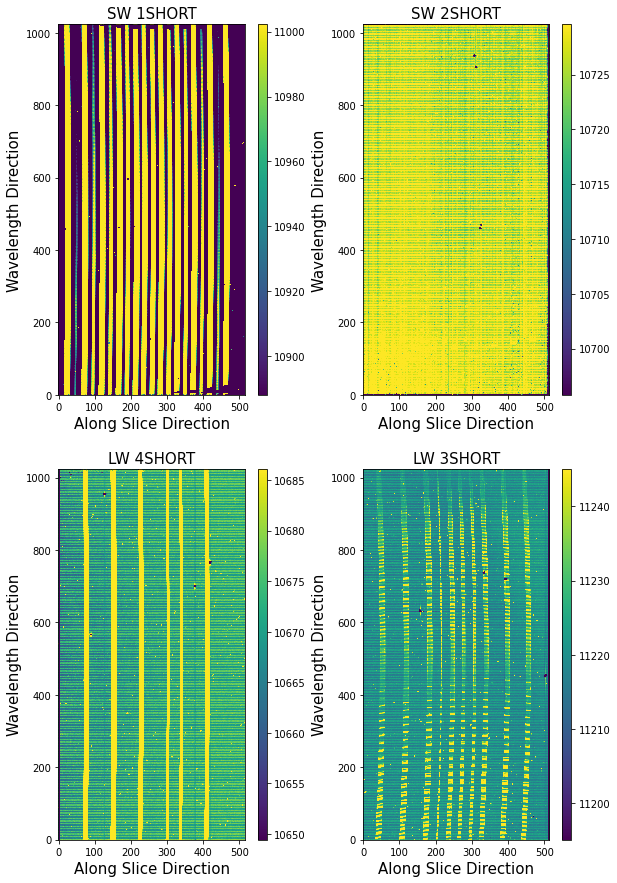

In [33]:
output_type='det_images'
infits = glob.glob('{}/{}/*.fits'.format(outputdir,output_type))


fig, axs = plt.subplots(2,2,figsize=(10,15))

from scipy import ndimage

for i in range(2):

    ax=axs[i,0]
    hdulist = fits.open(infits[i])
    hdu_index = 1
    integ,frames,nx,ny = hdulist[hdu_index].data.shape
    print(integ,frames,nx,ny)

    # If we want to just take the last integration and frame:
    image = hdulist[hdu_index].data[integ-1,frames-1,:,:]

    # If we want to average over all integrations/frames:
    image = hdulist[hdu_index].data.mean(axis=(0,1))

    
#     if i==0:
#         vmin=11000.
#         vmax=11500.
#     if i==1:
#         vmin=11100.
#         vmax=11800.

    sigma=100
    
    if i==0:
        pdata=image[:,0:516]
        blurred = ndimage.gaussian_filter(pdata, sigma=sigma)
        vmin=np.min(blurred)
        vmax=np.max(blurred)
        im=ax.imshow(pdata, origin = 'lower',cmap = cm.viridis,interpolation='nearest',vmin=vmin,vmax=vmax)
        ax.set_title('SW 1SHORT',size=15)
    if i==1:
        pdata=image[:,0:516]
        blurred = ndimage.gaussian_filter(pdata, sigma=sigma)
        vmin=np.min(blurred)
        vmax=np.max(blurred)
        im=ax.imshow(pdata, origin = 'lower',cmap = cm.viridis,interpolation='nearest',vmin=vmin,vmax=vmax)
        ax.set_title('LW 4SHORT',size=15)
    
    ax.set_xlabel('Along Slice Direction',size=15)
    ax.set_ylabel('Wavelength Direction',size=15)
    #ax.colorbar(ax=ax)

    
    clb = plt.colorbar(im,ax=ax,aspect=40)
    
    ax=axs[i,1]
    if i==0:
        pdata=image[:,517:1032]
        blurred = ndimage.gaussian_filter(pdata, sigma=sigma)
        vmin=np.min(blurred)
        vmax=np.max(blurred)
        im=ax.imshow(pdata, origin = 'lower',cmap = cm.viridis,interpolation='nearest',vmin=vmin,vmax=vmax)
        ax.set_title('SW 2SHORT',size=15)
    if i==1:
        pdata=image[:,517:1032]
        blurred = ndimage.gaussian_filter(pdata, sigma=sigma)
        vmin=np.min(blurred)
        vmax=np.max(blurred)
        im=ax.imshow(pdata, origin = 'lower',cmap = cm.viridis,interpolation='nearest',vmin=vmin,vmax=vmax)
        ax.set_title('LW 3SHORT',size=15)    
    ax.set_xlabel('Along Slice Direction',size=15)
    ax.set_ylabel('Wavelength Direction',size=15)
    #ax.colorbar(ax=ax)

    
    clb = plt.colorbar(im,ax=ax,aspect=40)

    
    
plt.savefig('detimage_UranusSHORT.png')

plt.show()

    
    

## Viewing Illumination Models

This should have the same format as the detector image, but without all of the detector effects and noise. There are FITS files produced for each exposure and dither position.


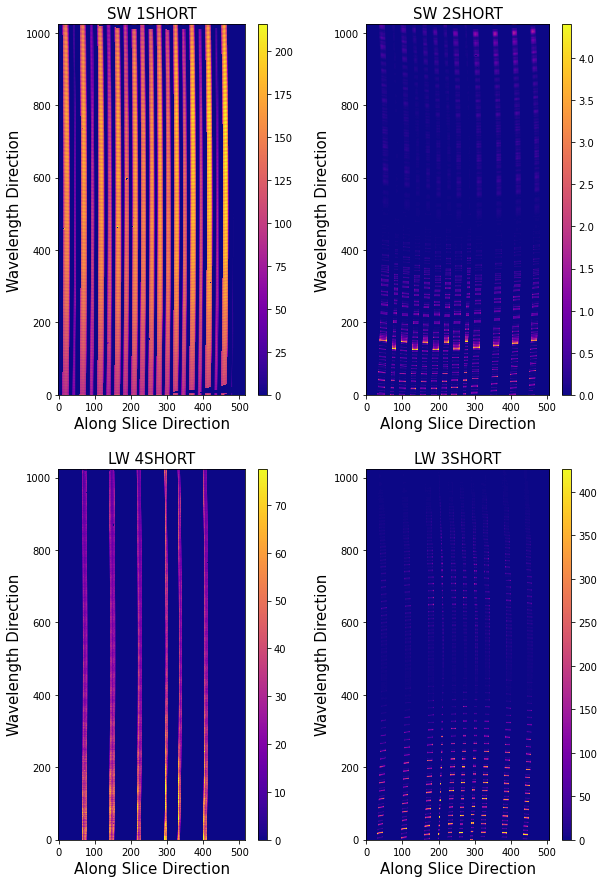

In [63]:
output_type='illum_models'
infits = glob.glob('{}/{}/*.fits'.format(outputdir,output_type))

fig, axs = plt.subplots(2,2,figsize=(10,15))

from scipy import ndimage


for i in range(2):

    ax=axs[i,0]
    hdulist = fits.open(infits[i])
    hdu_index = 1
    image = hdulist[hdu_index].data


    sigma=1.
    
    if i==0:
        pdata=image[:,0:516]
        blurred = ndimage.gaussian_filter(pdata, sigma=sigma)
        vmin=np.min(blurred)
        vmax=np.max(blurred)
        im=ax.imshow(pdata, origin = 'lower',cmap = cm.plasma,interpolation='nearest',vmin=vmin,vmax=vmax)
        ax.set_title('SW 1SHORT',size=15)
    if i==1:
        pdata=image[:,0:516]
        blurred = ndimage.gaussian_filter(pdata, sigma=sigma)
        vmin=np.min(blurred)
        vmax=np.max(blurred)
        im=ax.imshow(pdata, origin = 'lower',cmap = cm.plasma,interpolation='nearest',vmin=vmin,vmax=vmax)
        ax.set_title('LW 4SHORT',size=15)
    
    ax.set_xlabel('Along Slice Direction',size=15)
    ax.set_ylabel('Wavelength Direction',size=15)
    #ax.colorbar(ax=ax)

    
    clb = plt.colorbar(im,ax=ax,aspect=40)
    
    ax=axs[i,1]
    if i==0:
        pdata=image[:,517:1032]
        blurred = ndimage.gaussian_filter(pdata, sigma=sigma)
        vmin=np.min(blurred)
        vmax=np.max(blurred)
        im=ax.imshow(pdata, origin = 'lower',cmap = cm.plasma,interpolation='nearest',vmin=vmin,vmax=vmax)
        ax.set_title('SW 2SHORT',size=15)
    if i==1:
        pdata=image[:,517:1032]
        blurred = ndimage.gaussian_filter(pdata, sigma=sigma)
        vmin=np.min(blurred)
        vmax=np.max(blurred)
        im=ax.imshow(pdata, origin = 'lower',cmap = cm.plasma,interpolation='nearest',vmin=vmin,vmax=vmax)
        ax.set_title('LW 3SHORT',size=15)    
    ax.set_xlabel('Along Slice Direction',size=15)
    ax.set_ylabel('Wavelength Direction',size=15)
    #ax.colorbar(ax=ax)

    
    clb = plt.colorbar(im,ax=ax,aspect=40)

    
    
plt.savefig('illummodels_UranusSHORT.png')

plt.show()


    
    

['MIRIUranus_SHORT/skycubes/skycube_seq1_1SHORT.fits', 'MIRIUranus_SHORT/skycubes/skycube_seq1_3SHORT.fits', 'MIRIUranus_SHORT/skycubes/skycube_seq1_4SHORT.fits', 'MIRIUranus_SHORT/skycubes/skycube_seq1_2SHORT.fits']
MIRIUranus_SHORT/skycubes/skycube_seq1_1SHORT.fits
(1075, 21, 19)
537
MIRIUranus_SHORT/skycubes/skycube_seq1_3SHORT.fits
(1086, 16, 25)
543
MIRIUranus_SHORT/skycubes/skycube_seq1_4SHORT.fits
(841, 12, 29)
420
MIRIUranus_SHORT/skycubes/skycube_seq1_2SHORT.fits
(1086, 17, 23)
543


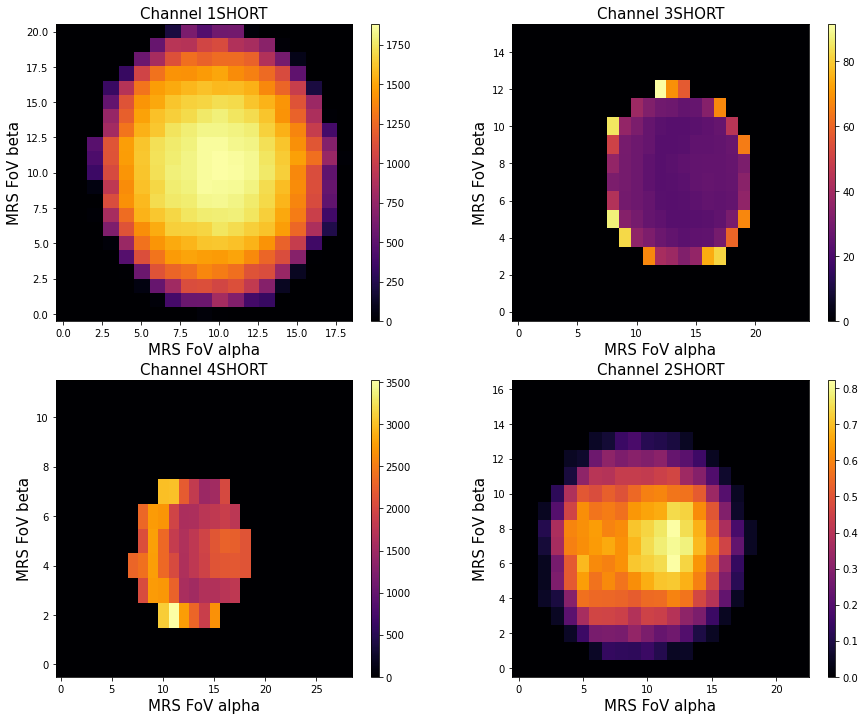

In [62]:
output_type='skycubes'
infits = glob.glob('{}/{}/*.fits'.format(outputdir,output_type))

fig, axs = plt.subplots(2,2,figsize=(15,12))


print(infits)

from scipy import ndimage

k=0

for i in range(2):
    for j in range(2):
        print(infits[k])
        ax=axs[i,j]
        hdulist = fits.open(infits[k])
        hdu_index = 0
        datashape = hdulist[hdu_index].data.shape
        print(datashape)
        central_chan = int(datashape[0]/2)
        print(central_chan)
        im=ax.imshow(hdulist[hdu_index].data[central_chan,:,:],
                  origin = 'lower', interpolation = 'nearest',cmap = cm.inferno,aspect=datashape[2]/datashape[1])
        if k==0:
            ax.set_title('Channel 1SHORT',size=15)
        if k==1:
            ax.set_title('Channel 3SHORT',size=15)
        if k==2:
            ax.set_title('Channel 4SHORT',size=15)
        if k==3:
            ax.set_title('Channel 2SHORT',size=15)
            
            
        ax.set_xlabel(hdulist[hdu_index].header['ctype1'],size=15)
        ax.set_ylabel(hdulist[hdu_index].header['ctype2'],size=15)
        clb = plt.colorbar(im,ax=ax,aspect=40)
        k=k+1
    


#     sigma=1.
    
#     if i==0:
#         pdata=image[:,0:516]
#         blurred = ndimage.gaussian_filter(pdata, sigma=sigma)
#         vmin=np.min(blurred)
#         vmax=np.max(blurred)
#         im=ax.imshow(pdata, origin = 'lower',cmap = cm.viridis,interpolation='nearest',vmin=vmin,vmax=vmax)
#         ax.set_title('SW 1SHORT',size=15)
#     if i==1:
#         pdata=image[:,0:516]
#         blurred = ndimage.gaussian_filter(pdata, sigma=sigma)
#         vmin=np.min(blurred)
#         vmax=np.max(blurred)
#         im=ax.imshow(pdata, origin = 'lower',cmap = cm.viridis,interpolation='nearest',vmin=vmin,vmax=vmax)
#         ax.set_title('LW 4SHORT',size=15)
    
#     ax.set_xlabel('Along Slice Direction',size=15)
#     ax.set_ylabel('Wavelength Direction',size=15)
#     #ax.colorbar(ax=ax)

    
#     clb = plt.colorbar(im,ax=ax,aspect=40)
    
#     ax=axs[i,1]
#     if i==0:
#         pdata=image[:,517:1032]
#         blurred = ndimage.gaussian_filter(pdata, sigma=sigma)
#         vmin=np.min(blurred)
#         vmax=np.max(blurred)
#         im=ax.imshow(pdata, origin = 'lower',cmap = cm.viridis,interpolation='nearest',vmin=vmin,vmax=vmax)
#         ax.set_title('SW 2SHORT',size=15)
#     if i==1:
#         pdata=image[:,517:1032]
#         blurred = ndimage.gaussian_filter(pdata, sigma=sigma)
#         vmin=np.min(blurred)
#         vmax=np.max(blurred)
#         im=ax.imshow(pdata, origin = 'lower',cmap = cm.viridis,interpolation='nearest',vmin=vmin,vmax=vmax)
#         ax.set_title('LW 3SHORT',size=15)    
#     ax.set_xlabel('Along Slice Direction',size=15)
#     ax.set_ylabel('Wavelength Direction',size=15)
#     #ax.colorbar(ax=ax)

    
#     clb = plt.colorbar(im,ax=ax,aspect=40)

    
    
plt.savefig('skycubes_UranusSHORT.png')

plt.show()


    
    

## Repeat for MEDIUM Setting

In [64]:
outputdir = 'MIRIUranus_MEDIUM'

outputDirContents = os.listdir(outputdir)

directories = [name for name in outputDirContents if os.path.isdir(os.path.join(outputdir,name))]
files = [name for name in outputDirContents if not os.path.isdir(os.path.join(outputdir,name))]

print('The subdirectories in the outputdirectory are:\n{}'.format(directories))
print('The files in the outputdirectory are:\n{}'.format(files))

The subdirectories in the outputdirectory are:
['det_images', 'skycubes', 'illum_models']
The files in the outputdirectory are:
['simulator.ini', 'scene.ini', 'mrs_recommended_dither.dat', 'simulation.ini', 'mirisim.log']


3 10 1024 1032
3 10 1024 1032


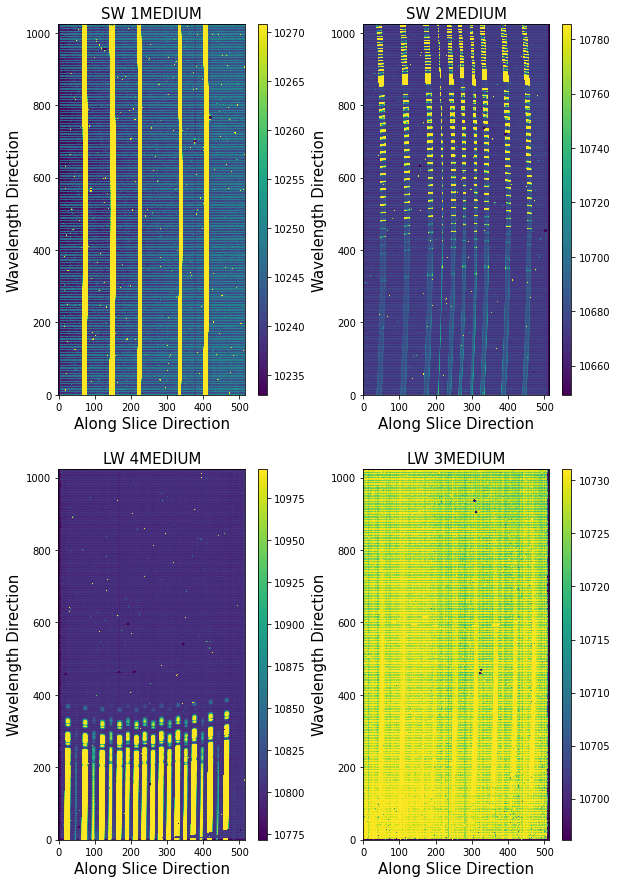

In [65]:
output_type='det_images'
infits = glob.glob('{}/{}/*.fits'.format(outputdir,output_type))


fig, axs = plt.subplots(2,2,figsize=(10,15))

from scipy import ndimage

for i in range(2):

    ax=axs[i,0]
    hdulist = fits.open(infits[i])
    hdu_index = 1
    integ,frames,nx,ny = hdulist[hdu_index].data.shape
    print(integ,frames,nx,ny)

    # If we want to just take the last integration and frame:
    image = hdulist[hdu_index].data[integ-1,frames-1,:,:]

    # If we want to average over all integrations/frames:
    image = hdulist[hdu_index].data.mean(axis=(0,1))

    
#     if i==0:
#         vmin=11000.
#         vmax=11500.
#     if i==1:
#         vmin=11100.
#         vmax=11800.

    sigma=100
    
    if i==0:
        pdata=image[:,0:516]
        blurred = ndimage.gaussian_filter(pdata, sigma=sigma)
        vmin=np.min(blurred)
        vmax=np.max(blurred)
        im=ax.imshow(pdata, origin = 'lower',cmap = cm.viridis,interpolation='nearest',vmin=vmin,vmax=vmax)
        ax.set_title('SW 1MEDIUM',size=15)
    if i==1:
        pdata=image[:,0:516]
        blurred = ndimage.gaussian_filter(pdata, sigma=sigma)
        vmin=np.min(blurred)
        vmax=np.max(blurred)
        im=ax.imshow(pdata, origin = 'lower',cmap = cm.viridis,interpolation='nearest',vmin=vmin,vmax=vmax)
        ax.set_title('LW 4MEDIUM',size=15)
    
    ax.set_xlabel('Along Slice Direction',size=15)
    ax.set_ylabel('Wavelength Direction',size=15)
    #ax.colorbar(ax=ax)

    
    clb = plt.colorbar(im,ax=ax,aspect=40)
    
    ax=axs[i,1]
    if i==0:
        pdata=image[:,517:1032]
        blurred = ndimage.gaussian_filter(pdata, sigma=sigma)
        vmin=np.min(blurred)
        vmax=np.max(blurred)
        im=ax.imshow(pdata, origin = 'lower',cmap = cm.viridis,interpolation='nearest',vmin=vmin,vmax=vmax)
        ax.set_title('SW 2MEDIUM',size=15)
    if i==1:
        pdata=image[:,517:1032]
        blurred = ndimage.gaussian_filter(pdata, sigma=sigma)
        vmin=np.min(blurred)
        vmax=np.max(blurred)
        im=ax.imshow(pdata, origin = 'lower',cmap = cm.viridis,interpolation='nearest',vmin=vmin,vmax=vmax)
        ax.set_title('LW 3MEDIUM',size=15)    
    ax.set_xlabel('Along Slice Direction',size=15)
    ax.set_ylabel('Wavelength Direction',size=15)
    #ax.colorbar(ax=ax)

    
    clb = plt.colorbar(im,ax=ax,aspect=40)

    
    
plt.savefig('detimage_UranusMEDIUM.png')

plt.show()

    
    

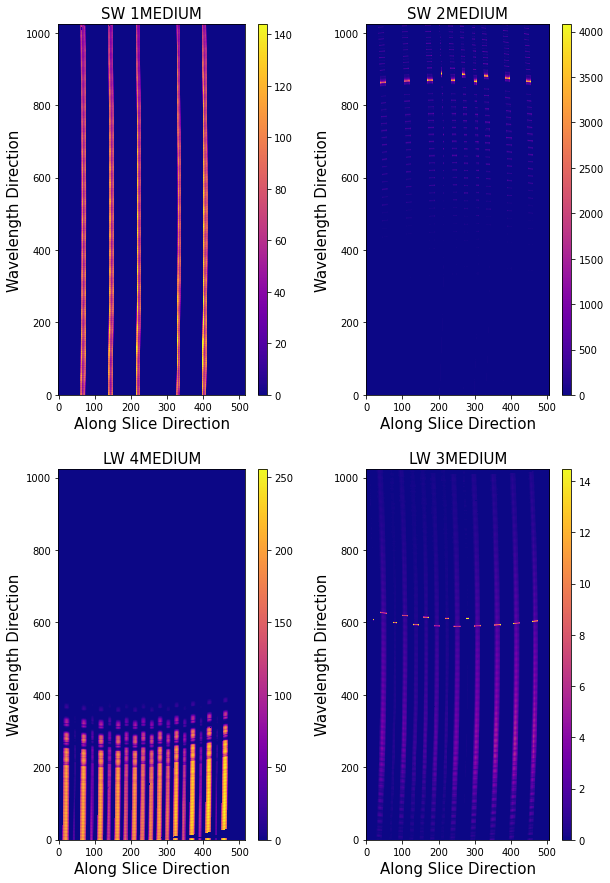

In [66]:
output_type='illum_models'
infits = glob.glob('{}/{}/*.fits'.format(outputdir,output_type))

fig, axs = plt.subplots(2,2,figsize=(10,15))

from scipy import ndimage


for i in range(2):

    ax=axs[i,0]
    hdulist = fits.open(infits[i])
    hdu_index = 1
    image = hdulist[hdu_index].data


    sigma=1.
    
    if i==0:
        pdata=image[:,0:516]
        blurred = ndimage.gaussian_filter(pdata, sigma=sigma)
        vmin=np.min(blurred)
        vmax=np.max(blurred)
        im=ax.imshow(pdata, origin = 'lower',cmap = cm.plasma,interpolation='nearest',vmin=vmin,vmax=vmax)
        ax.set_title('SW 1MEDIUM',size=15)
    if i==1:
        pdata=image[:,0:516]
        blurred = ndimage.gaussian_filter(pdata, sigma=sigma)
        vmin=np.min(blurred)
        vmax=np.max(blurred)
        im=ax.imshow(pdata, origin = 'lower',cmap = cm.plasma,interpolation='nearest',vmin=vmin,vmax=vmax)
        ax.set_title('LW 4MEDIUM',size=15)
    
    ax.set_xlabel('Along Slice Direction',size=15)
    ax.set_ylabel('Wavelength Direction',size=15)
    #ax.colorbar(ax=ax)

    
    clb = plt.colorbar(im,ax=ax,aspect=40)
    
    ax=axs[i,1]
    if i==0:
        pdata=image[:,517:1032]
        blurred = ndimage.gaussian_filter(pdata, sigma=sigma)
        vmin=np.min(blurred)
        vmax=np.max(blurred)
        im=ax.imshow(pdata, origin = 'lower',cmap = cm.plasma,interpolation='nearest',vmin=vmin,vmax=vmax)
        ax.set_title('SW 2MEDIUM',size=15)
    if i==1:
        pdata=image[:,517:1032]
        blurred = ndimage.gaussian_filter(pdata, sigma=sigma)
        vmin=np.min(blurred)
        vmax=np.max(blurred)
        im=ax.imshow(pdata, origin = 'lower',cmap = cm.plasma,interpolation='nearest',vmin=vmin,vmax=vmax)
        ax.set_title('LW 3MEDIUM',size=15)    
    ax.set_xlabel('Along Slice Direction',size=15)
    ax.set_ylabel('Wavelength Direction',size=15)
    #ax.colorbar(ax=ax)

    
    clb = plt.colorbar(im,ax=ax,aspect=40)

    
    
plt.savefig('illummodels_UranusMEDIUM.png')

plt.show()


    
    

['MIRIUranus_MEDIUM/skycubes/skycube_seq1_2MEDIUM.fits', 'MIRIUranus_MEDIUM/skycubes/skycube_seq1_3MEDIUM.fits', 'MIRIUranus_MEDIUM/skycubes/skycube_seq1_1MEDIUM.fits', 'MIRIUranus_MEDIUM/skycubes/skycube_seq1_4MEDIUM.fits']
MIRIUranus_MEDIUM/skycubes/skycube_seq1_2MEDIUM.fits
(1097, 17, 23)
548
MIRIUranus_MEDIUM/skycubes/skycube_seq1_3MEDIUM.fits
(1082, 16, 25)
541
MIRIUranus_MEDIUM/skycubes/skycube_seq1_1MEDIUM.fits
(1073, 21, 19)
536
MIRIUranus_MEDIUM/skycubes/skycube_seq1_4MEDIUM.fits
(841, 12, 29)
420


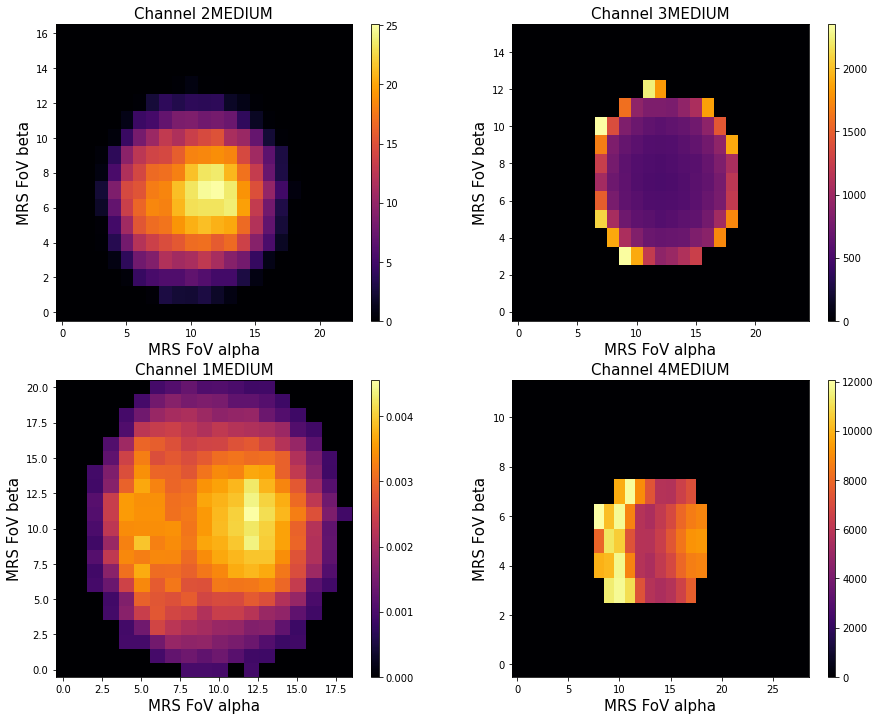

In [68]:
output_type='skycubes'
infits = glob.glob('{}/{}/*.fits'.format(outputdir,output_type))

fig, axs = plt.subplots(2,2,figsize=(15,12))


print(infits)

from scipy import ndimage

k=0

for i in range(2):
    for j in range(2):
        print(infits[k])
        ax=axs[i,j]
        hdulist = fits.open(infits[k])
        hdu_index = 0
        datashape = hdulist[hdu_index].data.shape
        print(datashape)
        central_chan = int(datashape[0]/2)
        print(central_chan)
        im=ax.imshow(hdulist[hdu_index].data[central_chan,:,:],
                  origin = 'lower', interpolation = 'nearest',cmap = cm.inferno,aspect=datashape[2]/datashape[1])
        if k==0:
            ax.set_title('Channel 2MEDIUM',size=15)
        if k==1:
            ax.set_title('Channel 3MEDIUM',size=15)
        if k==2:
            ax.set_title('Channel 1MEDIUM',size=15)
        if k==3:
            ax.set_title('Channel 4MEDIUM',size=15)
            
            
        ax.set_xlabel(hdulist[hdu_index].header['ctype1'],size=15)
        ax.set_ylabel(hdulist[hdu_index].header['ctype2'],size=15)
        clb = plt.colorbar(im,ax=ax,aspect=40)
        k=k+1
    


#     sigma=1.
    
#     if i==0:
#         pdata=image[:,0:516]
#         blurred = ndimage.gaussian_filter(pdata, sigma=sigma)
#         vmin=np.min(blurred)
#         vmax=np.max(blurred)
#         im=ax.imshow(pdata, origin = 'lower',cmap = cm.viridis,interpolation='nearest',vmin=vmin,vmax=vmax)
#         ax.set_title('SW 1SHORT',size=15)
#     if i==1:
#         pdata=image[:,0:516]
#         blurred = ndimage.gaussian_filter(pdata, sigma=sigma)
#         vmin=np.min(blurred)
#         vmax=np.max(blurred)
#         im=ax.imshow(pdata, origin = 'lower',cmap = cm.viridis,interpolation='nearest',vmin=vmin,vmax=vmax)
#         ax.set_title('LW 4SHORT',size=15)
    
#     ax.set_xlabel('Along Slice Direction',size=15)
#     ax.set_ylabel('Wavelength Direction',size=15)
#     #ax.colorbar(ax=ax)

    
#     clb = plt.colorbar(im,ax=ax,aspect=40)
    
#     ax=axs[i,1]
#     if i==0:
#         pdata=image[:,517:1032]
#         blurred = ndimage.gaussian_filter(pdata, sigma=sigma)
#         vmin=np.min(blurred)
#         vmax=np.max(blurred)
#         im=ax.imshow(pdata, origin = 'lower',cmap = cm.viridis,interpolation='nearest',vmin=vmin,vmax=vmax)
#         ax.set_title('SW 2SHORT',size=15)
#     if i==1:
#         pdata=image[:,517:1032]
#         blurred = ndimage.gaussian_filter(pdata, sigma=sigma)
#         vmin=np.min(blurred)
#         vmax=np.max(blurred)
#         im=ax.imshow(pdata, origin = 'lower',cmap = cm.viridis,interpolation='nearest',vmin=vmin,vmax=vmax)
#         ax.set_title('LW 3SHORT',size=15)    
#     ax.set_xlabel('Along Slice Direction',size=15)
#     ax.set_ylabel('Wavelength Direction',size=15)
#     #ax.colorbar(ax=ax)

    
#     clb = plt.colorbar(im,ax=ax,aspect=40)

    
    
plt.savefig('skycubes_UranusMEDIUM.png')

plt.show()


    
    

## Repeat for LONG Setting


In [69]:
outputdir = 'MIRIUranus_LONG'

outputDirContents = os.listdir(outputdir)

directories = [name for name in outputDirContents if os.path.isdir(os.path.join(outputdir,name))]
files = [name for name in outputDirContents if not os.path.isdir(os.path.join(outputdir,name))]

print('The subdirectories in the outputdirectory are:\n{}'.format(directories))
print('The files in the outputdirectory are:\n{}'.format(files))

The subdirectories in the outputdirectory are:
['det_images', 'skycubes', 'illum_models']
The files in the outputdirectory are:
['simulator.ini', 'scene.ini', 'mrs_recommended_dither.dat', 'simulation.ini', 'mirisim.log']


3 10 1024 1032
3 10 1024 1032


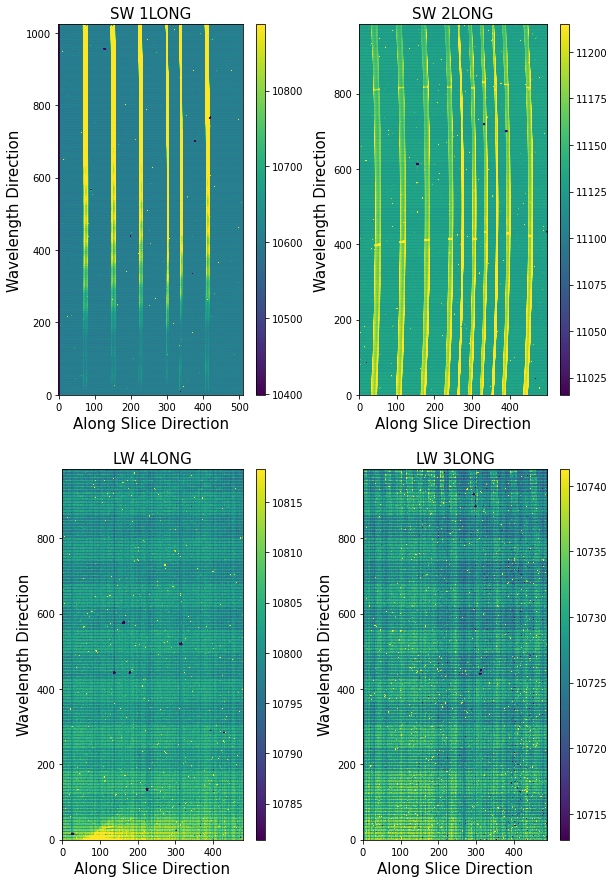

In [94]:
output_type='det_images'
infits = glob.glob('{}/{}/*.fits'.format(outputdir,output_type))


fig, axs = plt.subplots(2,2,figsize=(10,15))

from scipy import ndimage

for i in range(2):

    ax=axs[i,0]
    hdulist = fits.open(infits[i])
    hdu_index = 1
    integ,frames,nx,ny = hdulist[hdu_index].data.shape
    print(integ,frames,nx,ny)

    # If we want to just take the last integration and frame:
    image = hdulist[hdu_index].data[integ-1,frames-1,:,:]

    # If we want to average over all integrations/frames:
    image = hdulist[hdu_index].data.mean(axis=(0,1))

    
#     if i==0:
#         vmin=11000.
#         vmax=11500.
#     if i==1:
#         vmin=11100.
#         vmax=11800.

    sigma=10
    
    if i==0:
        pdata=image[:,0:510]
        blurred = ndimage.gaussian_filter(pdata, sigma=sigma)
        vmin=np.min(blurred)
        vmax=np.max(blurred)
        im=ax.imshow(pdata, origin = 'lower',cmap = cm.viridis,interpolation='nearest',vmin=vmin,vmax=vmax)
        ax.set_title('SW 1LONG',size=15)
    if i==1:
        sigma=20
        pdata=image[20:1004,30:510]
        blurred = ndimage.gaussian_filter(pdata, sigma=sigma)
        vmin=np.min(blurred)
        vmax=np.max(blurred)
        im=ax.imshow(pdata, origin = 'lower',cmap = cm.viridis,interpolation='nearest',vmin=vmin,vmax=vmax)
        ax.set_title('LW 4LONG',size=15)
    
    ax.set_xlabel('Along Slice Direction',size=15)
    ax.set_ylabel('Wavelength Direction',size=15)
    #ax.colorbar(ax=ax)

    
    clb = plt.colorbar(im,ax=ax,aspect=40)
    
    ax=axs[i,1]
    if i==0:
        pdata=image[20:1004,520:1020]
        blurred = ndimage.gaussian_filter(pdata, sigma=sigma)
        vmin=np.min(blurred)
        vmax=np.max(blurred)
        im=ax.imshow(pdata, origin = 'lower',cmap = cm.viridis,interpolation='nearest',vmin=vmin,vmax=vmax)
        ax.set_title('SW 2LONG',size=15)
    if i==1:
        sigma=20
        pdata=image[20:1004,530:1020]
        blurred = ndimage.gaussian_filter(pdata, sigma=sigma)
        vmin=np.min(blurred)
        vmax=np.max(blurred)
        im=ax.imshow(pdata, origin = 'lower',cmap = cm.viridis,interpolation='nearest',vmin=vmin,vmax=vmax)
        ax.set_title('LW 3LONG',size=15)    
    ax.set_xlabel('Along Slice Direction',size=15)
    ax.set_ylabel('Wavelength Direction',size=15)
    #ax.colorbar(ax=ax)

    
    clb = plt.colorbar(im,ax=ax,aspect=40)

    
    
plt.savefig('detimage_UranusLONG.png')

plt.show()

    
    

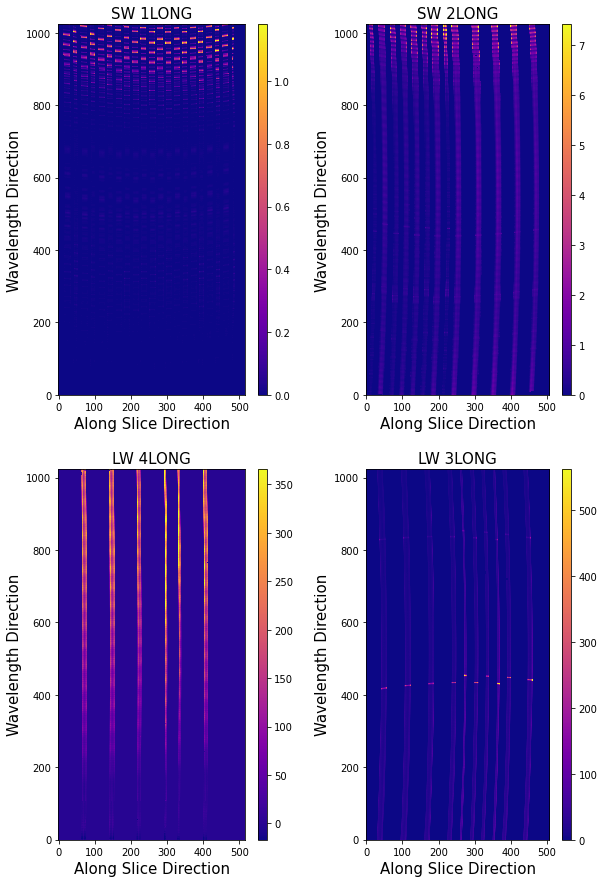

In [71]:
output_type='illum_models'
infits = glob.glob('{}/{}/*.fits'.format(outputdir,output_type))

fig, axs = plt.subplots(2,2,figsize=(10,15))

from scipy import ndimage


for i in range(2):

    ax=axs[i,0]
    hdulist = fits.open(infits[i])
    hdu_index = 1
    image = hdulist[hdu_index].data


    sigma=1.
    
    if i==0:
        pdata=image[:,0:516]
        blurred = ndimage.gaussian_filter(pdata, sigma=sigma)
        vmin=np.min(blurred)
        vmax=np.max(blurred)
        im=ax.imshow(pdata, origin = 'lower',cmap = cm.plasma,interpolation='nearest',vmin=vmin,vmax=vmax)
        ax.set_title('SW 1LONG',size=15)
    if i==1:
        pdata=image[:,0:516]
        blurred = ndimage.gaussian_filter(pdata, sigma=sigma)
        vmin=np.min(blurred)
        vmax=np.max(blurred)
        im=ax.imshow(pdata, origin = 'lower',cmap = cm.plasma,interpolation='nearest',vmin=vmin,vmax=vmax)
        ax.set_title('LW 4LONG',size=15)
    
    ax.set_xlabel('Along Slice Direction',size=15)
    ax.set_ylabel('Wavelength Direction',size=15)
    #ax.colorbar(ax=ax)

    
    clb = plt.colorbar(im,ax=ax,aspect=40)
    
    ax=axs[i,1]
    if i==0:
        pdata=image[:,517:1032]
        blurred = ndimage.gaussian_filter(pdata, sigma=sigma)
        vmin=np.min(blurred)
        vmax=np.max(blurred)
        im=ax.imshow(pdata, origin = 'lower',cmap = cm.plasma,interpolation='nearest',vmin=vmin,vmax=vmax)
        ax.set_title('SW 2LONG',size=15)
    if i==1:
        pdata=image[:,517:1032]
        blurred = ndimage.gaussian_filter(pdata, sigma=sigma)
        vmin=np.min(blurred)
        vmax=np.max(blurred)
        im=ax.imshow(pdata, origin = 'lower',cmap = cm.plasma,interpolation='nearest',vmin=vmin,vmax=vmax)
        ax.set_title('LW 3LONG',size=15)    
    ax.set_xlabel('Along Slice Direction',size=15)
    ax.set_ylabel('Wavelength Direction',size=15)
    #ax.colorbar(ax=ax)

    
    clb = plt.colorbar(im,ax=ax,aspect=40)

    
    
plt.savefig('illummodels_UranusLONG.png')

plt.show()


    
    

['MIRIUranus_LONG/skycubes/skycube_seq1_1LONG.fits', 'MIRIUranus_LONG/skycubes/skycube_seq1_4LONG.fits', 'MIRIUranus_LONG/skycubes/skycube_seq1_2LONG.fits', 'MIRIUranus_LONG/skycubes/skycube_seq1_3LONG.fits']
MIRIUranus_LONG/skycubes/skycube_seq1_1LONG.fits
(1051, 21, 19)
525
MIRIUranus_LONG/skycubes/skycube_seq1_4LONG.fits
(842, 12, 29)
421
MIRIUranus_LONG/skycubes/skycube_seq1_2LONG.fits
(1091, 17, 23)
545
MIRIUranus_LONG/skycubes/skycube_seq1_3LONG.fits
(1082, 16, 25)
541


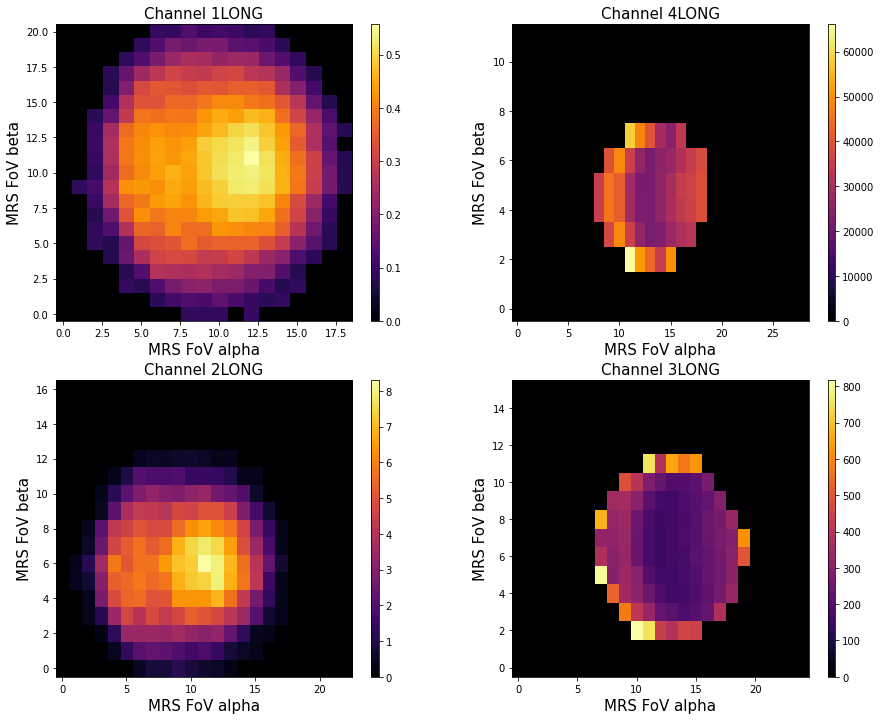

In [73]:
output_type='skycubes'
infits = glob.glob('{}/{}/*.fits'.format(outputdir,output_type))

fig, axs = plt.subplots(2,2,figsize=(15,12))


print(infits)

from scipy import ndimage

k=0

for i in range(2):
    for j in range(2):
        print(infits[k])
        ax=axs[i,j]
        hdulist = fits.open(infits[k])
        hdu_index = 0
        datashape = hdulist[hdu_index].data.shape
        print(datashape)
        central_chan = int(datashape[0]/2)
        print(central_chan)
        im=ax.imshow(hdulist[hdu_index].data[central_chan,:,:],
                  origin = 'lower', interpolation = 'nearest',cmap = cm.inferno,aspect=datashape[2]/datashape[1])
        if k==0:
            ax.set_title('Channel 1LONG',size=15)
        if k==1:
            ax.set_title('Channel 4LONG',size=15)
        if k==2:
            ax.set_title('Channel 2LONG',size=15)
        if k==3:
            ax.set_title('Channel 3LONG',size=15)
            
            
        ax.set_xlabel(hdulist[hdu_index].header['ctype1'],size=15)
        ax.set_ylabel(hdulist[hdu_index].header['ctype2'],size=15)
        clb = plt.colorbar(im,ax=ax,aspect=40)
        k=k+1
    


#     sigma=1.
    
#     if i==0:
#         pdata=image[:,0:516]
#         blurred = ndimage.gaussian_filter(pdata, sigma=sigma)
#         vmin=np.min(blurred)
#         vmax=np.max(blurred)
#         im=ax.imshow(pdata, origin = 'lower',cmap = cm.viridis,interpolation='nearest',vmin=vmin,vmax=vmax)
#         ax.set_title('SW 1SHORT',size=15)
#     if i==1:
#         pdata=image[:,0:516]
#         blurred = ndimage.gaussian_filter(pdata, sigma=sigma)
#         vmin=np.min(blurred)
#         vmax=np.max(blurred)
#         im=ax.imshow(pdata, origin = 'lower',cmap = cm.viridis,interpolation='nearest',vmin=vmin,vmax=vmax)
#         ax.set_title('LW 4SHORT',size=15)
    
#     ax.set_xlabel('Along Slice Direction',size=15)
#     ax.set_ylabel('Wavelength Direction',size=15)
#     #ax.colorbar(ax=ax)

    
#     clb = plt.colorbar(im,ax=ax,aspect=40)
    
#     ax=axs[i,1]
#     if i==0:
#         pdata=image[:,517:1032]
#         blurred = ndimage.gaussian_filter(pdata, sigma=sigma)
#         vmin=np.min(blurred)
#         vmax=np.max(blurred)
#         im=ax.imshow(pdata, origin = 'lower',cmap = cm.viridis,interpolation='nearest',vmin=vmin,vmax=vmax)
#         ax.set_title('SW 2SHORT',size=15)
#     if i==1:
#         pdata=image[:,517:1032]
#         blurred = ndimage.gaussian_filter(pdata, sigma=sigma)
#         vmin=np.min(blurred)
#         vmax=np.max(blurred)
#         im=ax.imshow(pdata, origin = 'lower',cmap = cm.viridis,interpolation='nearest',vmin=vmin,vmax=vmax)
#         ax.set_title('LW 3SHORT',size=15)    
#     ax.set_xlabel('Along Slice Direction',size=15)
#     ax.set_ylabel('Wavelength Direction',size=15)
#     #ax.colorbar(ax=ax)

    
#     clb = plt.colorbar(im,ax=ax,aspect=40)

    
    
plt.savefig('skycubes_UranusLONG.png')

plt.show()


    
    